## MNIST Code Along With a light CNN

### Perform Standard imports 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

### Load the MNIST dataset

In [46]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [47]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [48]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

### Create loaders 

In [49]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(train_data, batch_size=10, shuffle=False)

### Define a convolutional model 

In [206]:
# define layers 
conv1 = nn.Conv2d(1, 20, 5, 1)
conv2 = nn.Conv2d(20, 50, 5, 1)

In [207]:
# Grab the first MNIST record 
for i, (X_train, y_train) in enumerate(train_data):
    break

In [208]:
# Create a rank-4 tensor to be passed into the model 
X = X_train.view(1, 1, 28, 28)
print(X.shape)

torch.Size([1, 1, 28, 28])


In [209]:
# Perform the first convolution
X = conv1(X)
print(X.shape)

torch.Size([1, 20, 24, 24])


In [210]:
# Perform the 1st Average-Pooling 
X = F.avg_pool2d(X, 2, 2)
print(X.shape)

torch.Size([1, 20, 12, 12])


In [211]:
# Perform the second convolution
X = conv2(X)
print(X.shape)

torch.Size([1, 50, 8, 8])


In [212]:
# Perform the 2nd Average-Pooling 
X = F.avg_pool2d(X, 2, 2)
print(X.shape)

torch.Size([1, 50, 4, 4])


In [216]:
X = X.flatten(start_dim=1)
print(X.shape)

torch.Size([1, 800])


In [215]:
X = X.view(-1, 4*4*50)
X.shape

torch.Size([1, 800])

In [223]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.BN = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, X):
        X = F.avg_pool2d(self.conv1(X), 2, 2)
        X = F.avg_pool2d(self.conv2(X), 2, 2)
        X = X.view(-1, 4*4*50)
        X = self.fc1(X)
        X = F.relu(self.BN(X))
        X = self.fc2(X)
        return X

In [224]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (BN): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [225]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [226]:
count_parameters(model)

   500
    20
 25000
    50
400000
   500
   500
   500
  5000
    10
______
432080


### Define loss function & Optimize 

In [227]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model 

In [228]:
import time 
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches 
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model 
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results 
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # Run the testing batches 
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            # Apply the model 
            y_val = model(X_test)
            
            # Tally the number of correct predictions 
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    
print(f'\nDuration: {(time.time() - start_time:.0f)/60} min') # print the time elapsed            

epoch:  0  batch:  200 [  2000/60000]  loss: 0.75890863  accuracy:  76.800%
epoch:  0  batch:  400 [  4000/60000]  loss: 0.14805499  accuracy:  79.450%
epoch:  0  batch:  600 [  6000/60000]  loss: 0.67038077  accuracy:  81.917%
epoch:  0  batch:  800 [  8000/60000]  loss: 0.42437372  accuracy:  82.888%
epoch:  0  batch: 1000 [ 10000/60000]  loss: 0.14490001  accuracy:  83.570%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.58418375  accuracy:  84.417%
epoch:  0  batch: 1400 [ 14000/60000]  loss: 0.53928864  accuracy:  84.921%
epoch:  0  batch: 1600 [ 16000/60000]  loss: 0.21566351  accuracy:  85.581%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.26547885  accuracy:  86.028%
epoch:  0  batch: 2000 [ 20000/60000]  loss: 1.09380829  accuracy:  86.505%
epoch:  0  batch: 2200 [ 22000/60000]  loss: 0.21035838  accuracy:  86.991%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.07830124  accuracy:  87.292%
epoch:  0  batch: 2600 [ 26000/60000]  loss: 0.21694231  accuracy:  87.627%
epoch:  0  b

epoch:  3  batch: 3800 [ 38000/60000]  loss: 0.04221886  accuracy:  95.637%
epoch:  3  batch: 4000 [ 40000/60000]  loss: 0.06854652  accuracy:  95.665%
epoch:  3  batch: 4200 [ 42000/60000]  loss: 0.02833613  accuracy:  95.676%
epoch:  3  batch: 4400 [ 44000/60000]  loss: 0.05323910  accuracy:  95.664%
epoch:  3  batch: 4600 [ 46000/60000]  loss: 0.10421278  accuracy:  95.696%
epoch:  3  batch: 4800 [ 48000/60000]  loss: 0.03539827  accuracy:  95.698%
epoch:  3  batch: 5000 [ 50000/60000]  loss: 0.18015727  accuracy:  95.684%
epoch:  3  batch: 5200 [ 52000/60000]  loss: 0.22755030  accuracy:  95.685%
epoch:  3  batch: 5400 [ 54000/60000]  loss: 0.72414756  accuracy:  95.694%
epoch:  3  batch: 5600 [ 56000/60000]  loss: 0.00135767  accuracy:  95.695%
epoch:  3  batch: 5800 [ 58000/60000]  loss: 0.08198559  accuracy:  95.671%
epoch:  3  batch: 6000 [ 60000/60000]  loss: 0.00417643  accuracy:  95.677%
epoch:  4  batch:  200 [  2000/60000]  loss: 0.22252703  accuracy:  96.300%
epoch:  4  b

### Plot the Loss and Accuracy comparisons 

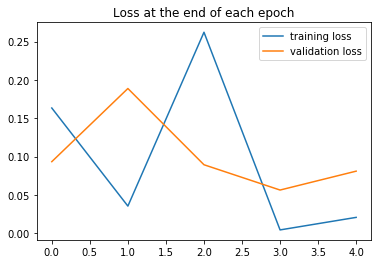

In [229]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [5]:
#plt.plot([t/200 for t in train_correct], label='training accuracy')
#plt.plot([t/100 for t in test_correct], label='validation accuracy')
#plt.title('Accuracy at the end of each epoch')
#plt.legend();

### Evaluate Test Data

In [231]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [232]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9814/10000 =  98.140%


### Display the confusion matrix

In [233]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 970    0    2    0    1    1    3    2    4    3]
 [   1 1129    3    0    0    1    2    6    1    2]
 [   1    1 1009    4    5    0    1   12    1    0]
 [   0    1    6  986    0    4    0    1    2    3]
 [   0    0    1    0  957    0    3    0    0    9]
 [   2    0    1   12    0  876    2    1    4    3]
 [   2    1    1    0    2    7  947    0    4    0]
 [   1    1    3    3    4    1    0 1001    1    6]
 [   1    2    6    3    0    2    0    3  956    0]
 [   2    0    0    2   13    0    0    2    1  983]]
